In [2]:
from custom_torch_dataset import SwipeDataset
import os
from torch.utils.data import random_split

dataset_path = os.path.join(os.getcwd(), "dataset")

data = SwipeDataset(data_dir=dataset_path,
                    batch=False)

train_set, val_set, test_set = random_split(data, [0.8, 0.1, 0.1])

In [ ]:
from torch.utils.data import Subset
reduced_set = Subset(data, range(200))
train_set, val_set, test_set = random_split(reduced_set, [0.8, 0.1, 0.1])

In [ ]:
data[0][2].shape

In [3]:
import torch
from torch.nn.utils.rnn import pack_sequence

def collate_fn(batch):
    """
    :param batch: List of tuples (input, word, word_tensor)
                  - input: (T, 6)
                  - word: a string of characters
                  - word_tensor: encoded word as indicies with 0 as the blank

    """
    # Sort batch by sequence length (descending order)
    batch.sort(key=lambda x: x[0].shape[0], reverse=True)

    inputs, words, targets = zip(*batch)
    input_lengths = torch.LongTensor([x.shape[0] for x in inputs])  # store the lengths of inputs
    input = pack_sequence(inputs)   # pack the inputs

    target_lengths = torch.LongTensor([len(x) for x in words])
    targets = torch.cat(targets)    # concatenate all the targets

    return input, targets, input_lengths, target_lengths, words

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)

dataloaders = {"train": train_loader,
               "val": val_loader}

In [ ]:
data[:][0][0].shape

In [ ]:
input_lengths = [x.shape[1] for x in data[:][0][:]]
max(input_lengths)

In [ ]:
test_in, test_word, test_tensor = next(iter(test_loader))

In [ ]:
import torch
from model import Seq2Seq

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
t_model = Seq2Seq(hidden_size=32,
                  num_layers=2, 
                  input_size=6, 
                  output_size=27).to(device)

In [ ]:
def train_batch(batch_indicies, set, model, criterion, device):
    """
    Takes a batch of variable lengths
    """
    for i in batch_indicies:
        input, word, word_tensor = set[i]
        input = input.to(device)
        word_tensor = word_tensor.to(device)

In [ ]:
import time
import random
import numpy as np
import torch.nn as nn

def train_model(model, train_set, val_set, optimiser, criterion=nn.CTCLoss(), batch_size=32, num_epochs=10):

    train_losses = []
    val_losses = []

    since = time.time()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "val"]:
            # set the mode of the model based on the phase and change the data used
            if phase == "train":
                model.train()
                batches = list(range(len(train_set)))
                data = train_set
            else:
                model.eval()
                batches = list(range(len(val_set)))
                data = val_set

            # batch like this because the words are of different lenghts and batching isnt used
            random.shuffle(batches)
            batches = np.array_split(batches, len(batches) // batch_size)

            running_loss = 0

            for batch in batches:   # iterate over each batch of dataset
                batch_loss = 0

                optimiser.zero_grad()
                # enable gradients only if in training mode
                with torch.set_grad_enabled(phase == "train"):
                    for i in batch:     # for every datapoint in the batch
                        input, word, word_tensor = data[i]

                        input = input.to(device)
                        word_tensor = word_tensor.to(device)
                        word_length = len(word)

                        output = t_model(input)
                        # rearrange the output for CTC loss
                        output = output.permute(1, 0, 2)    # (T, N, C)
                        # convert to tensors
                        input_lengths = torch.LongTensor([input.shape[1]]).to(device)
                        target_lengths = torch.LongTensor([word_length]).to(device)

                        loss = criterion(output, word_tensor, input_lengths, target_lengths)
                        batch_loss += loss
                    # find mean batch loss
                    avg_batch_loss = batch_loss / len(batch)

                    # back prop only if in train
                    if phase == "train":
                        avg_batch_loss.backward()
                        # clip the loss so we dont get exploding gradients
                        nn.utils.clip_grad_norm_(model.parameters(), 3)
                        optimiser.step()
                # calculates the total loss for epoch over all batches
                running_loss += avg_batch_loss.item()

            # track epoch oss
            if phase == "train":
                epoch_loss = running_loss / len(batches)
                train_losses.append(epoch_loss)
            else:
                epoch_loss = running_loss / len(batches)
                val_losses.append(epoch_loss)
            
            print(f'{phase} Loss: {epoch_loss:.4f}')

        time_elapsed = time.time() - since
        print(f"Time elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")       

    return model    

In [ ]:
import torch
from model import Seq2Seq

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
t_model = Seq2Seq(hidden_size=32,
                  num_layers=2, 
                  input_size=6, 
                  output_size=27).to(device)

optimiser = torch.optim.SGD(t_model.parameters(), lr=0.01)
criterion = nn.CTCLoss(blank=0)
t_model = train_model(t_model, train_set, val_set, optimiser,criterion, num_epochs=5, batch_size=32)

In [ ]:
test_in, test_word, test_ten = test_set[0]
test_in = test_in.to(device)

In [ ]:
test_out = t_model(test_in)

In [ ]:
vocabulary = {'_': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8,
              'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16,
              'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24,
              'y': 25, 'z': 26}
reversed_vocab = {k: u for u, k in vocabulary.items()}

In [ ]:
def handle_outputs(decoder_output):
    indicies = torch.argmax(decoder_output.squeeze(1), dim=-1).tolist()
    words = []
    for word in indicies:
        characters = [reversed_vocab[i] for i in word]
        words.append(characters)
    
    return words

In [ ]:
handle_outputs(test_out)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_sequence

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

class CTCEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, output_size=27, bidirectional=True, dropout = 0.5, lstm_dropout = 0):
        super(CTCEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout = dropout
        self.lstm_dropout = lstm_dropout
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=False,
                            bidirectional=bidirectional,
                            dropout=lstm_dropout)
        self.layer_norm = nn.LayerNorm(2 * hidden_size if bidirectional else hidden_size)
        self.drop = nn.Dropout(p=dropout)
        
        self.fc = nn.Linear(2 * hidden_size if bidirectional else hidden_size, output_size)
        
    def forward(self, x):
        """
        : param x: (batch_size, seq_len, input_size)
        : return logits: (seq_len, batch_size, output_size)
        """
        lstm_outputs, _ = self.lstm(x)  # lstm_out shape: (seq_len, batch_size, hidden_size*2 if bidirectional)

        lstm_out = pad_packed_sequence(lstm_outputs, batch_first=False)[0]
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = self.drop(lstm_out)

        logits = self.fc(lstm_out)  # shape: (batch_size, seq_len, output_size)
        return F.log_softmax(logits, dim=-1)  # Log-softmax for CTC loss
    
c_model = CTCEncoder(input_size=6,
                     hidden_size=32,
                     num_layers=2,
                     output_size=27,
                     bidirectional=True).to(device)

In [ ]:
t_inputs, t_targets, t_input_lengths, t_target_lengths, t_words = next(iter(train_loader))
t_output = c_model(t_inputs.to(device))

In [21]:
import torch
import time
from tempfile import TemporaryDirectory
import os
import matplotlib.pyplot as plt

class EarlyStopper:
    def __init__(self, patience=15, min_delta=0.05):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.counter = 0
            return False  # No early stopping
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Stop training
            return False

def CTCtrain(model, dataloaders, set_lengths, optimiser, num_epochs = 5, scheduler = None, patience = 15, min_delta = 0.05):
    criterion = torch.nn.CTCLoss(blank=0, zero_infinity=True)

    train_loss = []
    val_loss = []

    early_stopper = EarlyStopper(patience=patience, min_delta = min_delta)
    stop = False

    since = time.time()
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        lowest_loss = float("Inf")
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, targets, input_lengths, target_lengths, words in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    input_lengths = input_lengths.to(device)
                    target_lengths = target_lengths.to(device)

                    # zero the parameter gradients
                    optimiser.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, targets, input_lengths, target_lengths)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
                            loss.backward()
                            optimiser.step()

                    # statistics
                    running_loss += loss.item() * len(target_lengths)  # multiply by batch size
                if phase == 'train' and scheduler is not None:
                    scheduler.step(loss)

                epoch_loss = running_loss / set_lengths[phase]

                print(f'{phase} Loss: {epoch_loss:.4f}')
                
                if phase == "train":
                    train_loss.append(epoch_loss)
                else:
                    val_loss.append(epoch_loss)
                
                # early stop based on validation loss
                if phase == 'val':
                    stop = early_stopper.early_stop(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_loss < lowest_loss:
                    lowest_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)
                
            if stop:
                break
            
            time_elapsed = time.time() - since
            print(f"Time Elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Lowest Loss: {lowest_loss:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

        plt.plot(train_loss, label="Training Loss")
        plt.plot(val_loss, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.legend()
        plt.show
    return model

Epoch 1/150
----------
train Loss: 3.9353
val Loss: 3.1734
Time Elapsed: 0m 11s

Epoch 2/150
----------
train Loss: 3.1075
val Loss: 3.0199
Time Elapsed: 0m 22s

Epoch 3/150
----------
train Loss: 2.9766
val Loss: 2.8841
Time Elapsed: 0m 34s

Epoch 4/150
----------
train Loss: 2.8866
val Loss: 2.8120
Time Elapsed: 0m 45s

Epoch 5/150
----------
train Loss: 2.8065
val Loss: 2.7188
Time Elapsed: 0m 57s

Epoch 6/150
----------
train Loss: 2.7484
val Loss: 2.6747
Time Elapsed: 1m 8s

Epoch 7/150
----------
train Loss: 2.6467
val Loss: 2.5674
Time Elapsed: 1m 20s

Epoch 8/150
----------
train Loss: 2.5813
val Loss: 2.4962
Time Elapsed: 1m 31s

Epoch 9/150
----------
train Loss: 2.5223
val Loss: 2.4297
Time Elapsed: 1m 43s

Epoch 10/150
----------
train Loss: 2.4427
val Loss: 2.4035
Time Elapsed: 1m 54s

Epoch 11/150
----------
train Loss: 2.3925
val Loss: 2.3109
Time Elapsed: 2m 6s

Epoch 12/150
----------
train Loss: 2.3242
val Loss: 2.2787
Time Elapsed: 2m 17s

Epoch 13/150
----------
tra

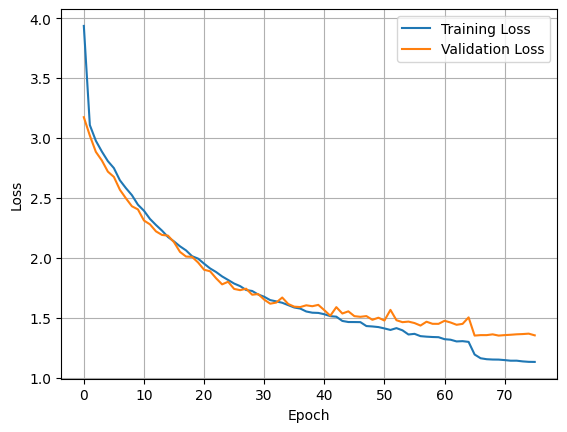

In [33]:
c_model = CTCEncoder(input_size=6,
                     hidden_size=90,
                     num_layers=2,
                     output_size=27,
                     bidirectional=True,
                     dropout=0.2,
                     lstm_dropout=0.2).to(device)

set_lengths = {"train":len(train_set),
               "val":len(val_set)}
optimiser = torch.optim.AdamW(c_model.parameters(), lr=0.001)
# optimiser = torch.optim.SGD(c_model.parameters(), lr=0.01, momentum=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.1)
c_model = CTCtrain(c_model, dataloaders,set_lengths, optimiser, num_epochs=150, scheduler=scheduler, patience = 10, min_delta = 0.01)

In [43]:
def test_model(model, test_data, datapoints):
    criterion = torch.nn.CTCLoss(blank=0, zero_infinity=True)

    model_outputs = []
    ground_truth = []
    # set the model into evaluation mode
    model.eval()

    running_loss = 0.0

    # Iterate over data.
    for inputs, targets, input_lengths, target_lengths, words in test_data:
        inputs = inputs.to(device)
        targets = targets.to(device)

        input_lengths = input_lengths.to(device)
        target_lengths = target_lengths.to(device)

        outputs = model(inputs)
        model_outputs.append(outputs.cpu())
        ground_truth.append(words)
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        
        running_loss += loss * len(target_lengths)  # multiply by batch size

    avg_loss = running_loss / datapoints    # average over the entire test set

    print(f"Average test loss: {avg_loss}")

    return model_outputs, ground_truth

In [61]:
logits, truth = test_model(c_model, test_loader, len(test_set))

Average test loss: 1.4904234409332275


In [46]:
logits[0].shape

torch.Size([331, 128, 27])

In [62]:
vocabulary = {'_': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8,
              'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16,
              'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24,
              'y': 25, 'z': 26}
reversed_vocab = {k: u for u, k in vocabulary.items()}

def greedy_decode(logits, ground_truth):
    decoded_words = []
    for batch, words in zip(logits, ground_truth):
        batched_results = []

        # for each sequence in the batch
        for b in range(batch.shape[1]):
            decoded_word = ""
            # at each timestep or letter
            for t in range(batch.shape[0]):
                timestep_logits = batch[t, b, :]   # get all the logits in that time step

                # Find the index of the maximum logit
                predicted_index = torch.argmax(timestep_logits).item()

                # Convert the index to a character using the reversed vocabulary
                predicted_char = reversed_vocab.get(predicted_index, '_') # Default to '_' if index not found

                if predicted_char != "_":
                    # Append the character to the decoded word
                    decoded_word += predicted_char

            batched_results.append(decoded_word)
        decoded_words.append(batched_results)

    return decoded_words

In [58]:
import torch
import torch.nn.functional as F
import heapq

def beam_search(logits, ground_truth, beam_width=3):
    """
    Decodes a tensor of logits using beam search, adapted for the provided input structure.

    Args:
        logits (torch.Tensor): A tensor of logits with shape (sequence_length, batch_size, vocab_size).
        ground_truth (list): A list of ground truth words (not directly used in beam search but included for consistency).
        reversed_vocab (dict): A dictionary mapping vocabulary indices to characters.
        beam_width (int): The width of the beam.

    Returns:
        list: A list of decoded strings, one for each sequence in the batch.
    """
    decoded_words = []
    for batch, _ in zip(logits, ground_truth):  # ground_truth is not used in the beam search.
        batched_results = []

        for b in range(batch.shape[1]):
            initial_beam = [([(0.0, "")], 0.0)]
            final_beams = []

            for t in range(batch.shape[0]):
                new_beam = []
                for seq, total_log_prob in initial_beam:
                    timestep_logits = batch[t, b, :]

                    topk_probs, topk_indices = torch.topk(timestep_logits, beam_width)

                    for i in range(beam_width):
                        char_index = topk_indices[i].item()
                        char = reversed_vocab.get(char_index, '_')
                        new_seq = seq + [(topk_probs[i].item(), char)]
                        new_total_log_prob = total_log_prob + topk_probs[i].item()
                        new_beam.append((new_seq, new_total_log_prob))

                initial_beam = heapq.nlargest(beam_width, new_beam, key=lambda x: x[1])

            best_sequence, _ = max(initial_beam, key=lambda x: x[1])
            decoded_word = "".join([char for log_prob, char in best_sequence[1:] if char != "_"])
            batched_results.append(decoded_word)

        decoded_words.append(batched_results)

    return decoded_words

In [53]:
decoded_words = greedy_decode(logits, truth)

In [60]:
beam_words = beam_search(logits, truth)